In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pygdsm import GlobalSkyModel
import uvtools
import healpy as hp
from scipy.interpolate import RectBivariateSpline
import aipy

In [2]:
CST_PATH = '/users/aewallwi/lustre/Vivaldi_Stripped_Down//Farfield/'
beamfiles = sorted(glob.glob(CST_PATH + '*.txt'))
beamfiles = beamfiles[-50:] + beamfiles[:-50]
beamfiles = beamfiles[:-1]

In [36]:
CST_PATH_DISH = '/users/aewallwi/lustre/Vivaldi feed + dish - detailed mecha design/Vivaldi 1.8m - detailed mecha design - E-field - 100 ohm load - Pol X/'
beamfiles_dish = sorted(glob.glob(CST_PATH_DISH + '*.txt'))
beamfiles_dish = beamfiles_dish[-50:] + beamfiles_dish[:-50]
beamfiles_dish = beamfiles_dish[:-1]

In [98]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split()[1][3:-1]) for f in beamfiles]) / 1000 # GHz
thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

In [99]:
NPIX = 129
L = np.linspace(-1, 1, NPIX,endpoint=True)
M = np.linspace(-1, 1, NPIX,endpoint=True)
L.shape = (-1, 1)
M.shape = ( 1,-1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2
N = np.where(LM < 1, np.sqrt(1 - LM), 0)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [100]:
mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(phis, thetas, d)(ph, th, grid=False)**2 for d in data])
beams.shape = (-1, NPIX, NPIX)
beams *= mask
print(beams.shape)

(200, 129, 129)


<IPython.core.display.Javascript object>


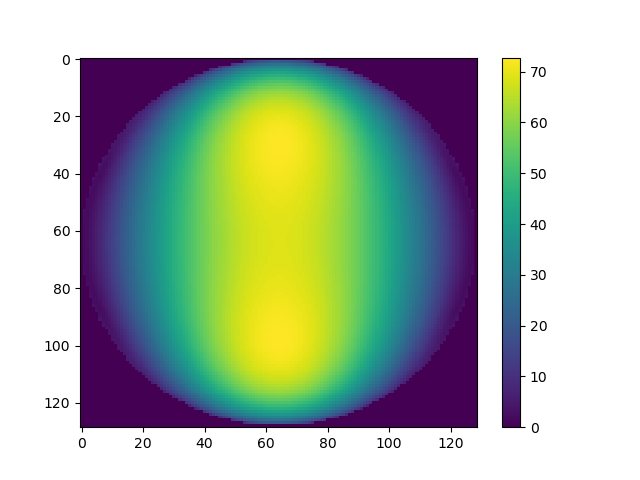

In [101]:
plt.figure()
uvtools.plot.waterfall(beams[100], mode='real')
plt.colorbar()

In [45]:
beamfiles_dish[0]

'/users/aewallwi/lustre/Vivaldi feed + dish - detailed mecha design/Vivaldi 1.8m - detailed mecha design - E-field - 100 ohm load - Pol X/farfield (f=50) [1].txt'

In [96]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split('=')[1].split(')')[0]) for f in beamfiles_dish]) / 1000 # GHz
thetas_dish, phis_dish = np.loadtxt(beamfiles_dish[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas_dish = np.deg2rad(np.unique(thetas_dish))
phis_dish = np.deg2rad(np.unique(phis_dish))
data_dish = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles_dish])
data_dish.shape = (-1, phis_dish.size, thetas.size)

<IPython.core.display.Javascript object>


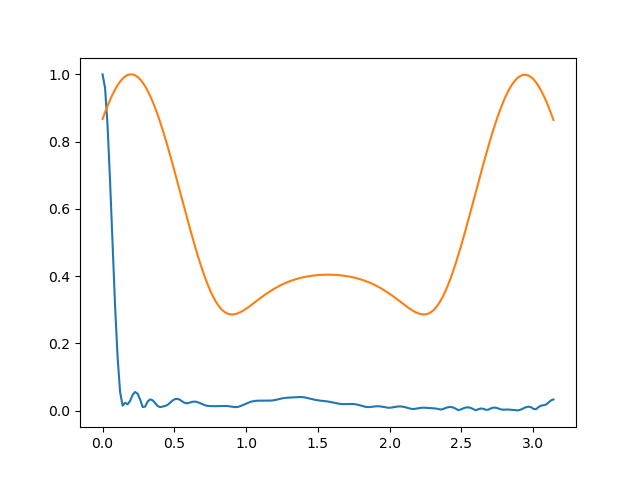

In [107]:
plt.figure()
plt.plot(thetas_dish, data_dish[-1,0,:]/data_dish[-1,0,:].max())
plt.plot(thetas, data[-1,0,:]/data[-1,0,:].max())

In [154]:
NPIX = 129
LD = np.linspace(-1, 1, NPIX,endpoint=True)
MD = np.linspace(-1, 1, NPIX,endpoint=True)
LD.shape = (-1, 1)
MD.shape = ( 1,-1)
LD = LD * np.ones_like(MD)
MD = MD * np.ones_like(LD)
LMD = LD**2 + MD**2
ND = np.where(LMD < 1, np.sqrt(1 - LMD), 0)
th_d = np.arcsin(LMD**.5).flatten()
ph_d = np.arctan2(MD, ND).flatten() - np.pi
ph_d = np.where(ph_d < 0, 2*np.pi+ph_d, ph_d)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arcsin
  # Remove the CWD from sys.path while we load stuff.


In [155]:
maskd = np.where(LMD < 1, 1, 0)
beams_dish = np.array([RectBivariateSpline(phis_dish, thetas_dish, d)(ph_d, th_d, grid=False)**2 for d in data_dish])
beams_dish.shape = (-1, NPIX, NPIX)
beams_dish *= maskd
print(beams_dish.shape)

(200, 129, 129)


<IPython.core.display.Javascript object>


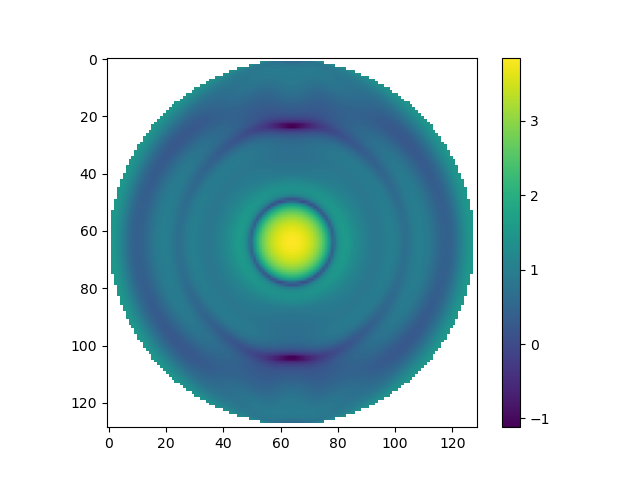

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [162]:
plt.figure()
plt.imshow(np.log10(beams_dish[100]))
plt.colorbar()

<IPython.core.display.Javascript object>


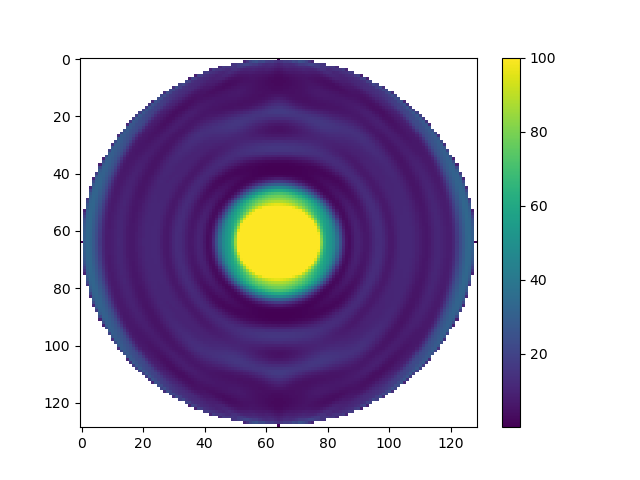

In [165]:
plt.figure()
uvtools.plot.waterfall(beams_dish[150], mode='abs', vmin=0.1, vmax=100)
plt.colorbar()

# Load up GSM

In [166]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [167]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

<IPython.core.display.Javascript object>


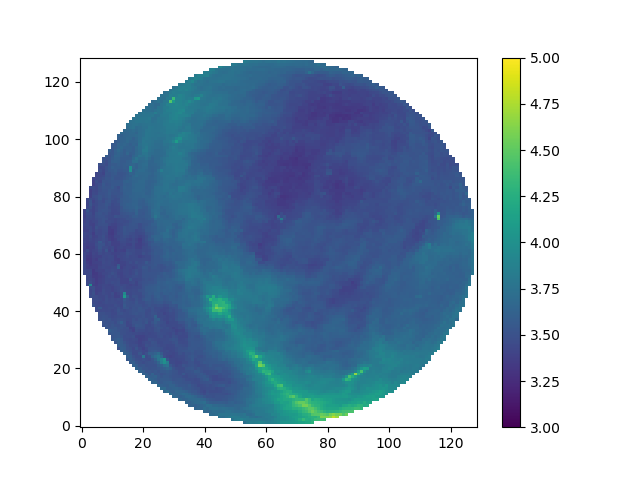

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/uvtools/plot.py:42: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


In [168]:
hpm = aipy.healpix.HealpixMap(nside=NSIDE)
hpm.map = I_sky[0]
top = (M.flatten(), L.flatten(), N.flatten())
gx,gy,gz = np.dot(np.linalg.inv(np.dot(eq2tops[150], ga2eq)), top)
img = hpm[gx,gy,gz]
img.shape = (NPIX,NPIX)
plt.figure()
uvtools.plot.waterfall(mask * img, mode='log', mx=5, drng=2, origin='lower')
_ = plt.colorbar()

In [169]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

Reading from file


In [170]:
if not os.path.exists('auto_dish.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data_dish = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data_dish[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams_dish[ch:ch+1])[:,0,0]
    np.savez('auto_dish.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto_dish.npz')
    data_dish = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_PO

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [171]:
def dayenu(dat, width=1.):
    _, rdat, _ = uvtools.dspec.fourier_filter(
                                x=freqs * 1e9,
                                data=dat,
                                wgts=np.ones_like(dat),
                                mode='dpss_leastsq',
                                filter_centers=[0.],
                                filter_half_widths=[width * 1e-9],
                                eigenval_cutoff=[1e-12],
                                suppression_factors=[1e-9]
    )
    return rdat

rdata = dayenu(data / data[55]) * data[55]

In [172]:
ARES_PATH = '../../'
models = np.load(ARES_PATH + 'models_21cm.npz')['models'] / 1e3 # K
mfreqs = np.load(ARES_PATH + 'models_21cm.npz')['freqs']

In [173]:
fake_eor = models[78]


In [174]:
gain = beams[:,NPIX//2+1,NPIX//2+1]
avg = np.mean(data[-50:], axis=0) / gain
cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]
idata = cal * data / gain + fake_eor

<IPython.core.display.Javascript object>


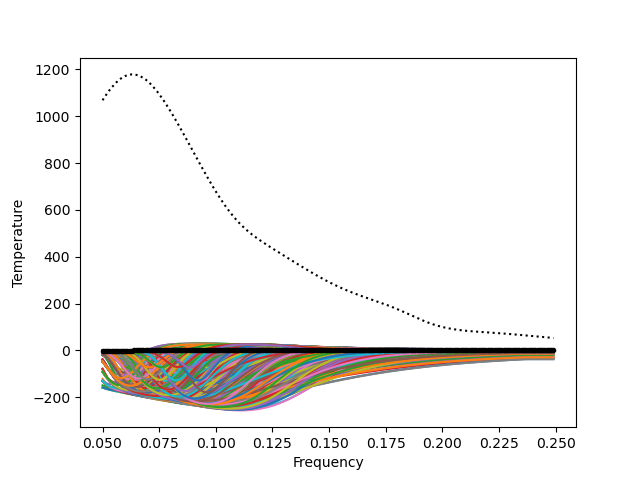

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [175]:
def gen_eor(A, nu0, w, tau):
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

prms = {
    'A': 0.52,
    'nu0': 78.3e-3,
    'w': 20.7e-3,
    'tau': 6.5,
}
#fake_eor = gen_eor(**prms)
#fake_eor = models[185]

plt.figure()

for mdl in models:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*fake_eor, 'k.-')
plt.plot(freqs, idata[0], 'k:')

plt.xlabel('Frequency')
_ = plt.ylabel('Temperature')

In [20]:
#def dayenu(data):
#    return data

idata = cal * data / gain + fake_eor

# Build a filter to exclude EoR from calibration signal
d = idata - np.mean(idata[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)
#plt.figure(); plt.plot(S)
iS = np.identity(S.size)
#iS[10:,10:] = 0
iS[5:,5:] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))
#pcal = idata[55] - 0.5 * fake_eor # XXX
pcal = np.dot(Cinv, idata[55]) # filter to exclude most of eor signal

reor = dayenu(fake_eor / pcal) * pcal
rmodels = dayenu(models / pcal) * pcal

idata = dayenu(idata / pcal) * pcal

<IPython.core.display.Javascript object>


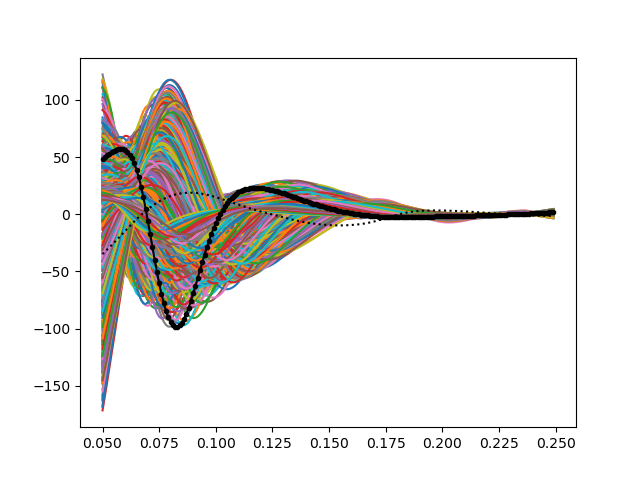

In [536]:
plt.figure()
for mdl in rmodels:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*reor, 'k.-')
plt.plot(freqs, idata[0], 'k:')

In [537]:
d = idata - np.mean(idata[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)

In [538]:
m = rmodels - np.mean(rmodels, axis=0)
Cm = np.dot(m.T, m)
Um, Sm, Vm = np.linalg.svd(Cm)

<IPython.core.display.Javascript object>


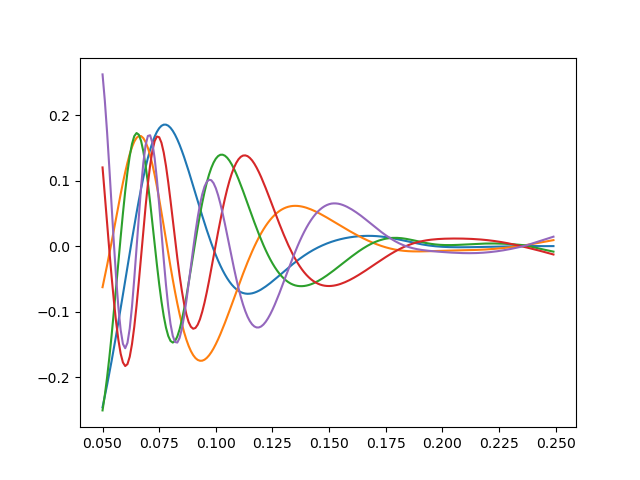

In [539]:
plt.figure()
_ = plt.plot(freqs, Vm[:5].T)

<IPython.core.display.Javascript object>


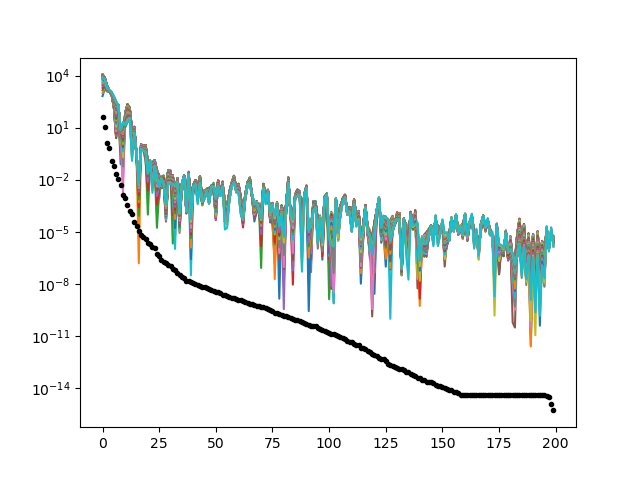

In [540]:
plt.figure()
plt.semilogy(np.abs(np.dot(Vm, idata[-50:].T))**2)
_ = plt.semilogy(Sm, 'k.')

<IPython.core.display.Javascript object>


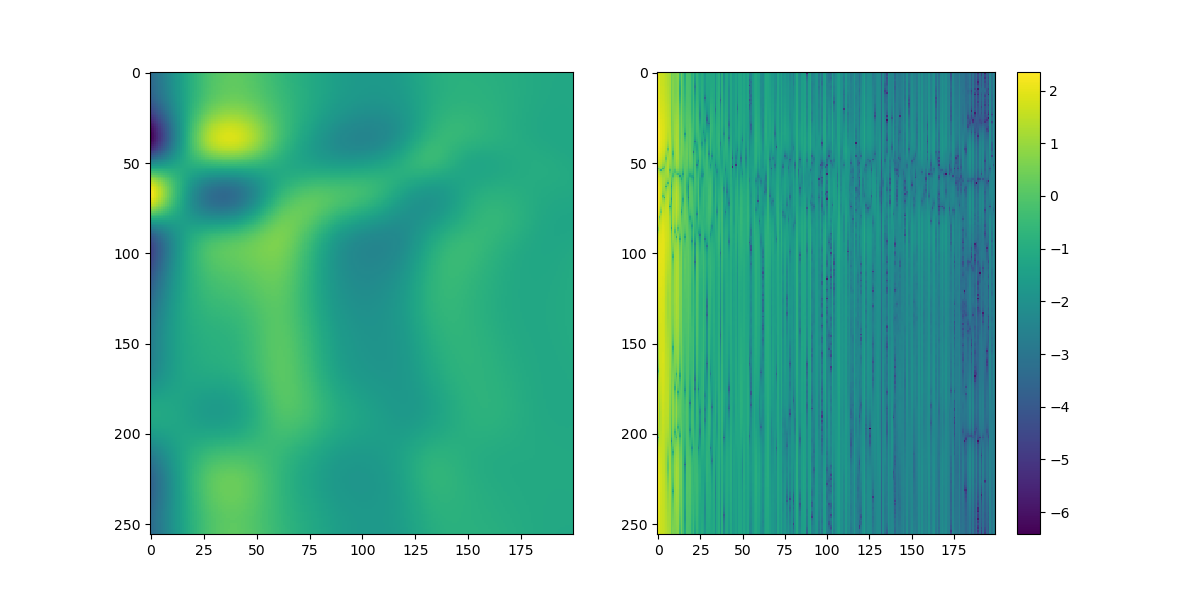

In [541]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vm, idata.T).T, mode='log')
_ = plt.colorbar()

<IPython.core.display.Javascript object>


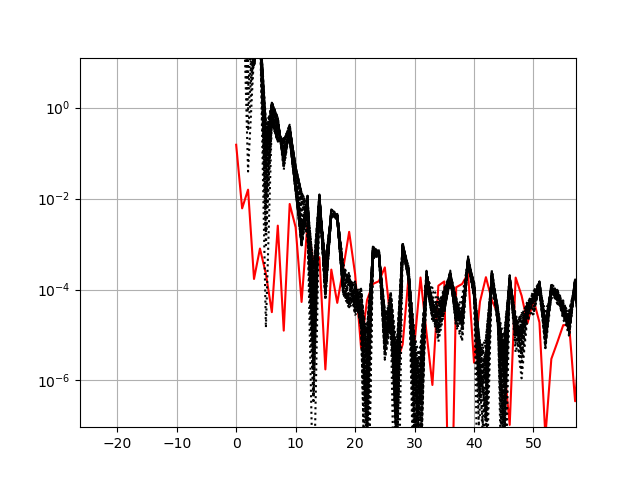

(646, 200)


In [542]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(V, reor))**2,'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(V, (idata[-50:] - reor).T))**2, 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()

In [543]:
iS = np.identity(S.size)
#np.fill_diagonal(iS, np.where(S > 1e12, 1e12/S, 1))
#np.fill_diagonal(iS, 4e-7/S.clip(4e-7, np.Inf))
iS[:18,:18] = 0
#iS[:16,:16] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))

<IPython.core.display.Javascript object>


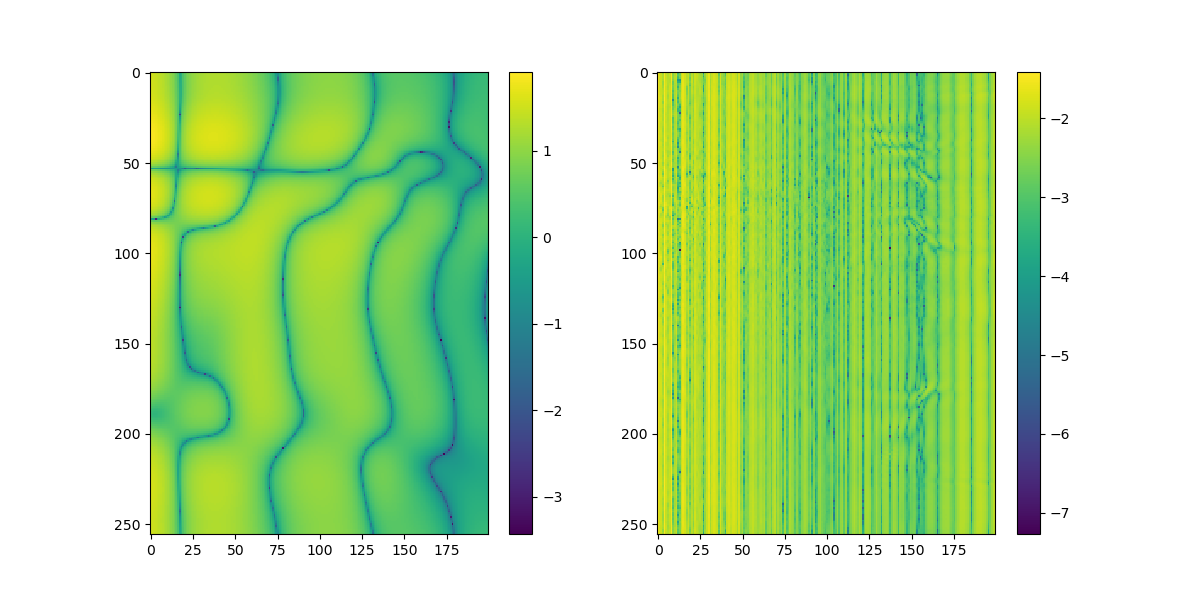

In [544]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata, mode='log')
plt.colorbar()
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Cinv, idata.T).T, mode='log')
plt.colorbar()

<IPython.core.display.Javascript object>


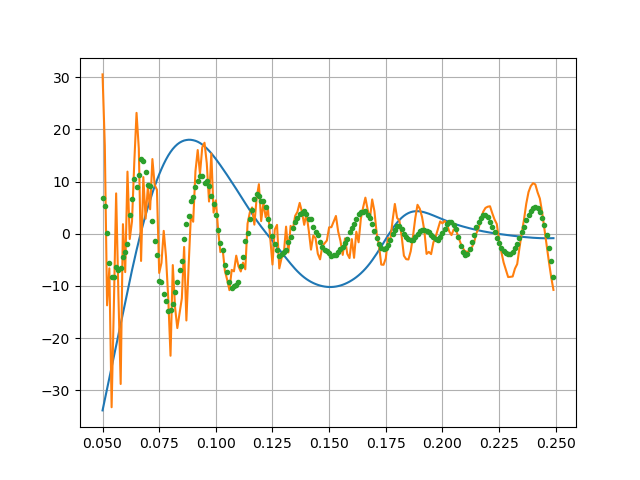

In [545]:
plt.figure()
plt.plot(freqs, np.mean(idata[-50:], axis=0))
plt.plot(freqs, 1e3*np.mean(np.dot(Cinv, idata[-50:].T).T, axis=0))
plt.plot(freqs, 1e3*np.dot(Cinv, reor), '.')
plt.grid()

In [546]:
detect = np.mean(np.dot(Cinv, idata.T).T, axis=0)
template = np.dot(Cinv, reor)
print(np.dot(detect, template) / np.dot(template, template))

(1.0422329104738215+0j)
